In [27]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

import numpy as np
import random
import json
import re
from torch.utils.data import Dataset, DataLoader

import nltk
from selenium import webdriver
from pprint import pprint
import requests 
from bs4 import BeautifulSoup
import unicodedata
import pandas as pd
import ast

import nltk
from nltk.corpus import stopwords

In [28]:
def unicode(text):
    return unicodedata.normalize("NFKD", text)

def processQues(chat):
    chat = chat.lower()
    chat = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',chat)
    chat = re.sub('@[^\s]+','',chat)
    chat = re.sub('[\s]+', ' ', chat)
    chat = re.sub('\[\d+\]+', ' ', chat)
    chat = re.sub(r'#([^\s]+)', r'\1', chat)
    chat = re.sub(r'[\!:\?\-\'\"\\/]', r'', chat)
    chat = chat.strip('\'"')
    return chat

def get_relation(sent):
    doc = nlp(sent)
    matcher = Matcher(nlp.vocab)
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 
    matcher.add("matching_1", None, pattern) 
    matches = matcher(doc)
    k = len(matches) - 1
    span = doc[matches[k][1]:matches[k][2]] 
    return(span.text)

In [29]:
def get_entities(sent):
    ent1 = ""
    ent2 = ""
    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence
    prefix = ""
    modifier = ""
    for tok in nlp(sent):
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " "+ tok.text

            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""      

            ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier +" "+ prefix +" "+ tok.text

            ## chunk 5  
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    return [ent1.strip(), ent2.strip()]

In [30]:
def GetDocs(link):
    response = requests.get(link)
    soup = BeautifulSoup(response.text, "html.parser" )
    soup=soup.find('div',{'class':'mw-parser-output'})
    final_para=[]
    for i in soup.find_all('p'):
        para=processQues(i.getText()).strip().split(".")
        for j in para:
            p_len=len(j.strip().split(" "))
            if(p_len < 3):
                pass
            else:
                subs=0
                objs=0
                doc = nlp(j)
                for tok in doc:
                    if (tok.dep_=="nsubj" or tok.dep_=="nsubjpass"):
                        subs+=1
                    elif tok.dep_=="pobj":
                        objs+=1
                if (subs>1 or objs>1 or subs<1 or objs<1):
                    pass
                else:
                    final_para.append(unicode(j))
    data=pd.DataFrame(final_para, columns =['sentence'])
    return data

In [31]:
def knowledge_graph(link):
    data=GetDocs(link)
    entity_pairs = []

    for i in tqdm(data["sentence"]):
        entity_pairs.append(get_entities(i))

    relations = [get_relation(i) for i in tqdm(data['sentence'])]
    print(relations)
    return relations, entity_pairs

In [32]:
print("Please enter the link")
link=input()
data=knowledge_graph(link)

Please enter the link
https://en.wikipedia.org/wiki/Narendra_Modi


100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 110.90it/s]

['elected to', 'found', 'received', 'criticised for', 'initiated', 'characters in theatrical', 'put', 'driven to', 'continued', 'gave', 'filed', 'retained', 'continued', 'authored', 'irrigated', 'followed', 'changed', 'benefit', 'attended hindu', 'maintain', 'succeeded', 'played', 'cost', 'started', 'launched', 'resolved', 'ordered', 'lowered corporate', 'deregulated', 'subsumed', 'set', 'linked to', 'launched new', 'viewed', 'rose by', 'launched', 'signed', 'launched', 'plans', 'continued', 'renamed', 'increased', 'lifted', 'maintains', 'described by', 'was of', 'authored', 'continues']


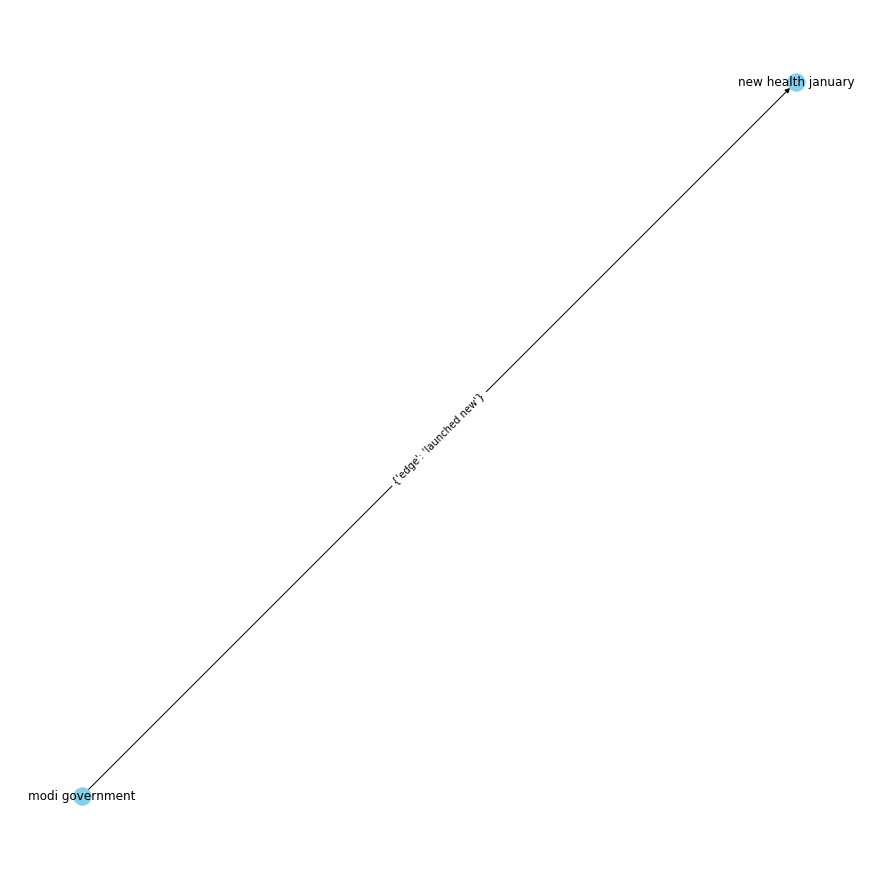

In [43]:
# extract subject
relations=data[0]
entity_pairs=data[1]
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

#based on filter
relation_name='launched new'
if(relation_name==""):
    G=nx.from_pandas_edgelist(kg_df, "source", "target",edge_attr=True, create_using=nx.MultiDiGraph())
else:
    G=nx.from_pandas_edgelist(kg_df[kg_df['edge']==relation_name], "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
nx.draw_networkx_edge_labels(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()